## Autoencoders implementation

We will be working with the well known MNIST dataset. To download MNIST into your local folder, run this:

In [1]:
from urllib import request
import gzip
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
# Download the files
url = "http://yann.lecun.com/exdb/mnist/"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []
for filename in filenames:
    print("Downloading", filename)
    request.urlretrieve(url + filename, filename)
    with gzip.open(filename, 'rb') as f:
        if 'labels' in filename:
            # Load the labels as a one-dimensional array of integers
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # Load the images as a two-dimensional array of pixels
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28))

# Split into training and testing sets
X_train_np, y_train, X_test_np, y_test = data

# Normalize the pixel values
X_train_np = X_train_np.astype(np.float32) / 255.0
X_test_np = X_test_np.astype(np.float32) / 255.0

# Convert labels to integers
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

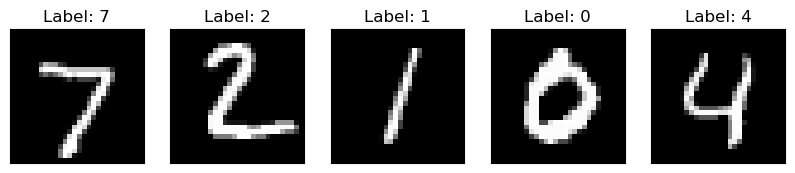

In [3]:
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        if labels is not None:
          axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

show_images(X_test_np[:5], y_test[:5])

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self, num_hidden=8):
        super().__init__()

        # Set the number of hidden units
        self.num_hidden = num_hidden

        # Define the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),  # input size: 784, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, self.num_hidden),  # input size: 256, output size: num_hidden
            nn.ReLU(),  # apply the ReLU activation function
        )

        # Define the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            nn.Linear(self.num_hidden, 256),  # input size: num_hidden, output size: 256
            nn.ReLU(),  # apply the ReLU activation function
            nn.Linear(256, 784),  # input size: 256, output size: 784
            nn.Sigmoid(),  # apply the sigmoid activation function to compress the output to a range of (0, 1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
def train(model, batch_size=64, learning_rate=1e-3, num_epochs=15):

  # Convert the training data to PyTorch tensors
  X_train = torch.from_numpy(X_train_np)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Define the loss function
  criterion = nn.MSELoss()

  # Set the device to GPU if available, otherwise use CPU
  model.to(device)

  # Create a DataLoader to handle batching of the training data
  train_loader = torch.utils.data.DataLoader(
      X_train, batch_size=batch_size, shuffle=True
  )

  model.train()

  # Training loop
  for epoch in range(num_epochs):
      total_loss = 0.0
      for batch_idx, data in enumerate(train_loader):
          # Get a batch of training data and move it to the device
          data = data.to(device)

          # Forward pass
          encoded, decoded = model(data)

          # Compute the loss and perform backpropagation
          loss = criterion(decoded, data)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Update the running loss
          total_loss += loss.item() * data.size(0)

      # Print the epoch loss
      epoch_loss = total_loss / len(train_loader.dataset)
      print(
          "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
      )

In [7]:
def reconstruct(model, X_test, y_test):

  model.eval()
  with torch.no_grad():
    decoded = model(X_test.to(device))[1].cpu()

  show_images(X_test[:5], y_test[:5])
  show_images(decoded[:5], y_test[:5])


Epoch 1/15: loss=0.0584
Epoch 2/15: loss=0.0507
Epoch 3/15: loss=0.0459
Epoch 4/15: loss=0.0377
Epoch 5/15: loss=0.0355
Epoch 6/15: loss=0.0342
Epoch 7/15: loss=0.0334
Epoch 8/15: loss=0.0327
Epoch 9/15: loss=0.0322
Epoch 10/15: loss=0.0318
Epoch 11/15: loss=0.0314
Epoch 12/15: loss=0.0311
Epoch 13/15: loss=0.0309
Epoch 14/15: loss=0.0306
Epoch 15/15: loss=0.0304


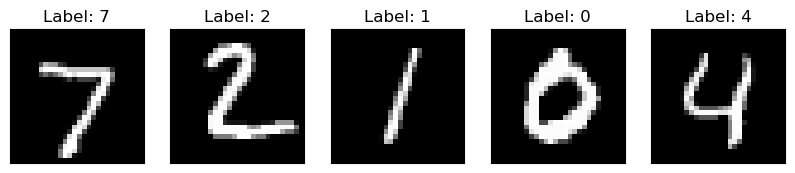

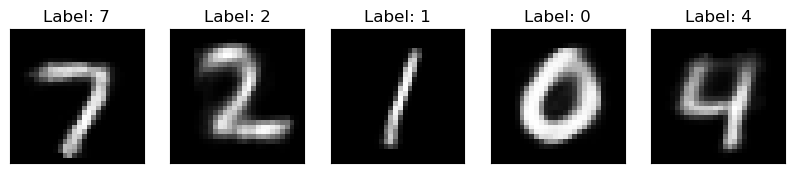

In [17]:
model = AutoEncoder(num_hidden=8)

train(model)

reconstruct(model, torch.from_numpy(X_test_np[:100]), y_test[:100])

Epoch 1/15: loss=0.0312
Epoch 2/15: loss=0.0139
Epoch 3/15: loss=0.0114
Epoch 4/15: loss=0.0102
Epoch 5/15: loss=0.0094
Epoch 6/15: loss=0.0089
Epoch 7/15: loss=0.0085
Epoch 8/15: loss=0.0082
Epoch 9/15: loss=0.0080
Epoch 10/15: loss=0.0078
Epoch 11/15: loss=0.0076
Epoch 12/15: loss=0.0075
Epoch 13/15: loss=0.0073
Epoch 14/15: loss=0.0072
Epoch 15/15: loss=0.0071


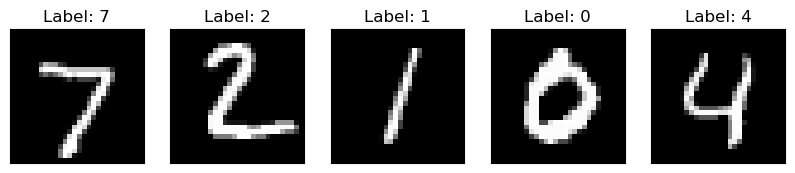

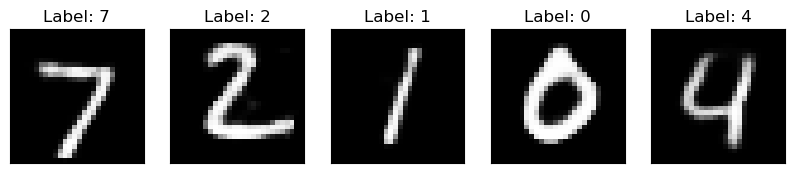

In [13]:
model = AutoEncoder(num_hidden=32)

train(model)

reconstruct(model, torch.from_numpy(X_test_np[:100]), y_test[:100])

Epoch 1/15: loss=0.0561
Epoch 2/15: loss=0.0491
Epoch 3/15: loss=0.0470
Epoch 4/15: loss=0.0458
Epoch 5/15: loss=0.0450
Epoch 6/15: loss=0.0444
Epoch 7/15: loss=0.0439
Epoch 8/15: loss=0.0435
Epoch 9/15: loss=0.0432
Epoch 10/15: loss=0.0428
Epoch 11/15: loss=0.0425
Epoch 12/15: loss=0.0422
Epoch 13/15: loss=0.0419
Epoch 14/15: loss=0.0417
Epoch 15/15: loss=0.0414


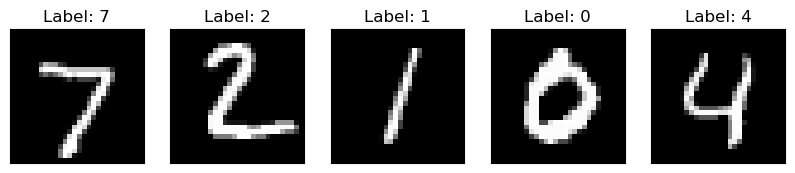

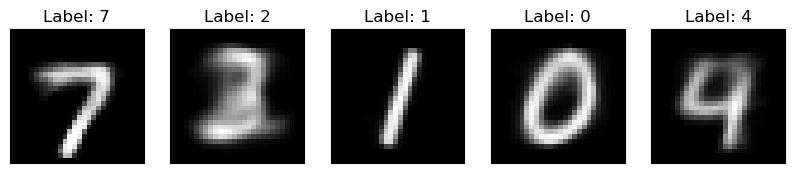

In [20]:
model = AutoEncoder(num_hidden=2)

train(model)

reconstruct(model, torch.from_numpy(X_test_np[:100]), y_test[:100])

In [21]:
def sample_ae(model, num_samples=5):
  print(f"samplin from AE with {model.num_hidden} latent dim")
  model.eval()
  with torch.no_grad():
    latent = torch.randn(num_samples, model.num_hidden, device=device)
    decoded = model.decoder(latent)


  show_images(decoded[:num_samples].cpu(), labels=None)


samplin from AE with 2 latent dim


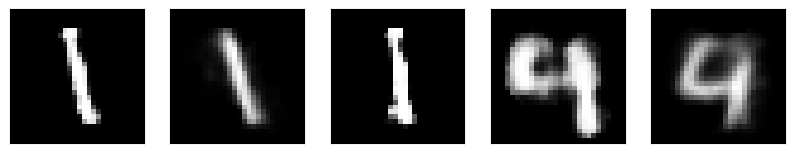

In [30]:
sample_ae(model, num_samples=5)

## Variational Autoencoders

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*kxB-Zgp4l5FgNRqE.png)

In [31]:
class VAE(AutoEncoder):
    def __init__(self, num_hidden=8):
        super().__init__(num_hidden=num_hidden)
        # Add mu and log_var layers for reparameterization
        self.mu = nn.Linear(self.num_hidden, self.num_hidden)
        self.log_var = nn.Linear(self.num_hidden, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)

        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)

        # Return the reparameterized sample
        return mu + eps * std

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)

        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)

        # Pass the latent variable through the decoder
        decoded = self.decoder(z)

        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)

        # Return the generated samples
        return samples

In [32]:
# Define a loss function that combines MSE and Kullback-Leibler divergence
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    # Compute the MSE loss between the reconstructed output and the input data
    MSE = F.mse_loss(recon_x, x.view(-1, 784), reduction="sum")

    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return MSE + lamb * KLD

The first component we are already familiar with — it’s just reconstruction error. The second component introduces penalty for the learned distribution to deviate too much from the prior distribution. Our prior distribution is just a bunch of zero-centred unit variance normal distributions.

So to train the model we simple can use:

In [33]:
def train_vae(model, batch_size=64, learning_rate=1e-3, num_epochs=15):
    # Convert the training data to PyTorch tensors
    X_train = torch.from_numpy(X_train_np)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            # Get a batch of training data and move it to the device
            data = data.to(device)

            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, data, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

Epoch 1/15: loss=54.1937
Epoch 2/15: loss=49.6600
Epoch 3/15: loss=47.8223
Epoch 4/15: loss=46.8851
Epoch 5/15: loss=46.4168
Epoch 6/15: loss=46.0312
Epoch 7/15: loss=45.7939
Epoch 8/15: loss=45.5557
Epoch 9/15: loss=45.3164
Epoch 10/15: loss=45.1527
Epoch 11/15: loss=45.0443
Epoch 12/15: loss=44.9148
Epoch 13/15: loss=44.7942
Epoch 14/15: loss=44.7017
Epoch 15/15: loss=44.6426


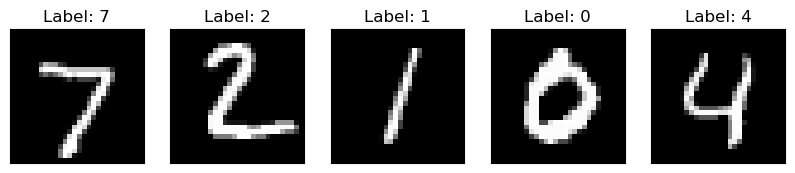

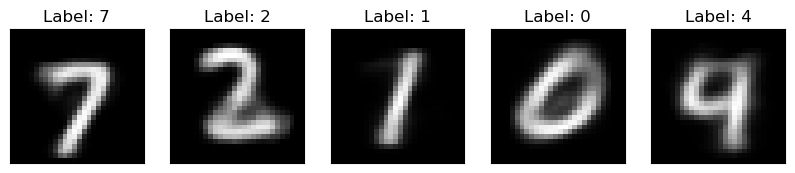

In [34]:
model = VAE(num_hidden=8)

train_vae(model)

reconstruct(model, torch.from_numpy(X_test_np[:100]), y_test[:100])

In [35]:
def sample_vae(model, num_samples=5):
  print(f"samplin from VAE with {model.num_hidden} latent dim")
  model.eval()

  decoded = model.sample(num_samples)

  show_images(decoded[:num_samples].cpu(), labels=None)

samplin from VAE with 8 latent dim


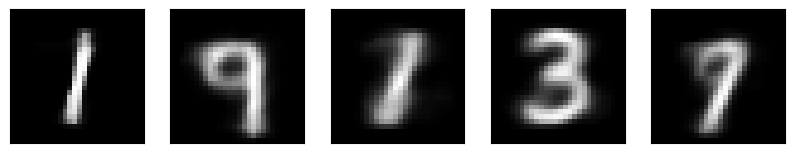

In [38]:
sample_vae(model, num_samples=5)

One last thing that is quite fun to do is to generate a random vector, then gradually change one of it’s components while keeping other components fixed. That way we are able to see how the output of the decoder changes. Here are a few examples:

In [41]:
def traverse_latent(model, traverse=5):
  model.eval()
  samples = []
  with torch.no_grad():
      z = torch.randn(1, model.num_hidden).to(device)

      for i in range(traverse):
        sample = model.decoder(z)
        samples.append(sample.cpu())

        c_z = torch.randn(1).to(device) * 10
        z[:, 0] += c_z


  show_images(torch.stack(samples)[:traverse], labels=None)


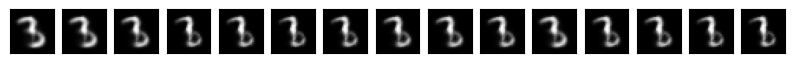

In [48]:
traverse_latent(model, traverse=15)

## Conditional Variational Autoencoders(CVAE)

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*wSiHXUxJX_gCL22j.png)

In [50]:
class ConditionalVAE(VAE):
    # VAE implementation from the article linked above
    def __init__(self, num_classes, num_hidden):
        super().__init__(num_hidden)

        self.num_classes = num_classes

        # Add a linear layer for the class label
        self.label_projector = nn.Sequential(
            nn.Linear(self.num_classes,self.num_hidden),nn.ReLU(),
        )

    def condition_on_label(self, z, y):
        projected_label = self.label_projector(F.one_hot(y.long(), self.num_classes).float())
        return z + projected_label

    def forward(self, x, y):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)

        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(self.condition_on_label(z, y))

        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(self.condition_on_label(z, y))

        # Return the generated samples
        return samples

Notice, there is a new layer called `label_projector` that does that linear projection. Also, the latent code is passed through that layer both during forward pass and sampling processes.

A CVAE is trained with exactly the same loss function as it’s non-conditioned buddy. Here is the loss

In [51]:
def train_cvae(model, batch_size=64, learning_rate=1e-3, num_epochs=15):
    # Convert the training data to PyTorch tensors
    X_tr = torch.from_numpy(X_train_np)
    y_tr = torch.from_numpy(y_train)[:, None]

    X_train = torch.cat([X_tr, y_tr], dim=1)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            # Get a batch of training data and move it to the device
            data = data.to(device)
            x = data[:, :-1] # B, 784
            y = data[:, -1] # B, 1

            # Forward pass
            encoded, decoded, mu, log_var = model(x=x, y=y)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, x, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        ) 

In [53]:
def reconstruct_conditional(model, X_test, y_test):

  model.eval()
  with torch.no_grad():
    decoded = model(X_test.to(device), y_test.to(device))[1].cpu()

  show_images(X_test[:5], y_test[:5])
  show_images(decoded[:5], y_test[:5])


Epoch 1/15: loss=50.5667
Epoch 2/15: loss=43.4789
Epoch 3/15: loss=41.5187
Epoch 4/15: loss=40.3330
Epoch 5/15: loss=39.4950
Epoch 6/15: loss=39.0319
Epoch 7/15: loss=38.5991
Epoch 8/15: loss=38.2980
Epoch 9/15: loss=38.0890
Epoch 10/15: loss=37.8475
Epoch 11/15: loss=37.6223
Epoch 12/15: loss=37.4726
Epoch 13/15: loss=37.3244
Epoch 14/15: loss=37.2297
Epoch 15/15: loss=37.0903


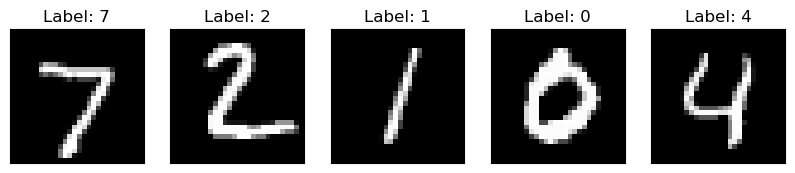

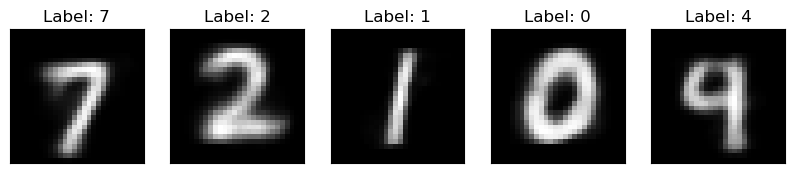

In [54]:
model = ConditionalVAE(num_classes=10, num_hidden=8)

train_cvae(model)

reconstruct_conditional(model, torch.from_numpy(X_test_np[:100]), torch.from_numpy(y_test[:100]))

In [55]:
def sample_cvae(model, labels, num_samples=5):

  assert len(labels) == num_samples, "labels must == samples"

  print(f"samplin from CVAE with {model.num_hidden} latent dim")
  model.eval()

  decoded = model.sample(num_samples, torch.LongTensor(labels).to(device))

  show_images(decoded[:num_samples].cpu(), labels=labels)

samplin from CVAE with 8 latent dim


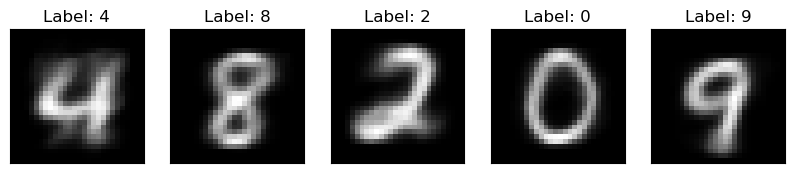

In [64]:
sample_cvae(model, labels=[4, 8, 2, 0, 9], num_samples=5)